## Import libraries

In [1]:
!unzip /content/doi_10.5061_dryad.gt413__v1.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
!pip install nilearn

     ---------------------------------------- 3.3/3.3 MB 10.0 MB/s eta 0:00:00
  Attempting uninstall: nibabel
    Found existing installation: nibabel 3.1.1
    Uninstalling nibabel-3.1.1:
      Successfully uninstalled nibabel-3.1.1

[notice] A new release of pip available: 22.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import nilearn as nil
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

from nilearn import image
from nilearn import masking
#from nilearn.plotting import image
from pathlib import Path

## Read in fmri data

doi_10.5061_dryad.gt413__v1 is the name of the folder of all data taken from: https://datadryad.org/stash/dataset/doi:10.5061/dryad.gt413

This folder contains a description of the data files included as well as .mat files for subjects 1-8, readme files for each subject, and a story feature .mat file.


**For our purposes we are only interested on the subject_X.mat files.**

In [2]:
fMRI_folder = Path('./doi_10.5061_dryad.gt413__v1')
#fMRI_folder = Path('/content')
assert fMRI_folder.exists(), f"Folder: {fMRI_folder} does not exist."

mat_files = sorted(list(fMRI_folder.glob('subject_*.mat')))

## Build 4d matrix
The subject_X.mat files contain matrices in the size of [ number of voxels X 1351 TRs ] and a mapping of the 3D coordinates of each voxel.
The below function maps each voxel in the 2D matrix to its corresponding location to form the 4D brain volumes.

In [3]:
# Builds a matrix of shape (x,y,z,nTRs) for a subject
#
# Params:
# x_dim: maximum x coord
# y_dim: maximum y coord
# z_dim: maximum z coord
# nTRs: number of total fmri scans
# data: fmri data of shape (nTRs, nVoxels)
# colToCoord: maps each voxel in data to its 3d coordinates
#
# Returns: matrix of shape (x,y,z,nTRs) with each voxel having its BOLD data

def build_4d_matrix(x_dim,y_dim,z_dim,nTRs,data,colToCoord):
    matrix = np.zeros((x_dim,y_dim,z_dim,nTRs))
    #print(matrix.shape)
    for voxel_id in range(data.shape[1]):
        x,y,z = colToCoord[voxel_id]
        matrix[x-1, y-1, z-1, :] = data[:,voxel_id]
    return matrix

For each subject_X.mat file, the 4D brain volumes will be contructed and a .nii image will be created.

dict_keys(['__header__', '__version__', '__globals__', 'data', 'time', 'words', 'meta'])
(1351, 37913)
(53, 60, 50, 1351)
dict_keys(['__header__', '__version__', '__globals__', 'data', 'time', 'words', 'meta'])
(1351, 33740)
(51, 60, 49, 1351)
dict_keys(['__header__', '__version__', '__globals__', 'data', 'time', 'words', 'meta'])
(1351, 29307)
(53, 59, 47, 1351)
dict_keys(['__header__', '__version__', '__globals__', 'data', 'time', 'words', 'meta'])
(1351, 26851)
(53, 59, 44, 1351)
dict_keys(['__header__', '__version__', '__globals__', 'data', 'time', 'words', 'meta'])
(1351, 27073)
(51, 59, 45, 1351)
dict_keys(['__header__', '__version__', '__globals__', 'data', 'time', 'words', 'meta'])
(1351, 34837)
(49, 56, 51, 1351)
dict_keys(['__header__', '__version__', '__globals__', 'data', 'time', 'words', 'meta'])
(1351, 30689)
(52, 60, 49, 1351)
dict_keys(['__header__', '__version__', '__globals__', 'data', 'time', 'words', 'meta'])
(1351, 31047)
(52, 60, 48, 1351)


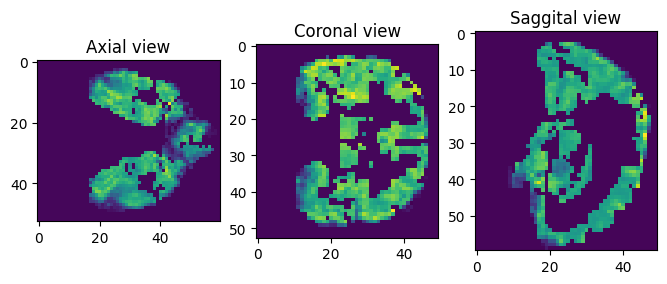

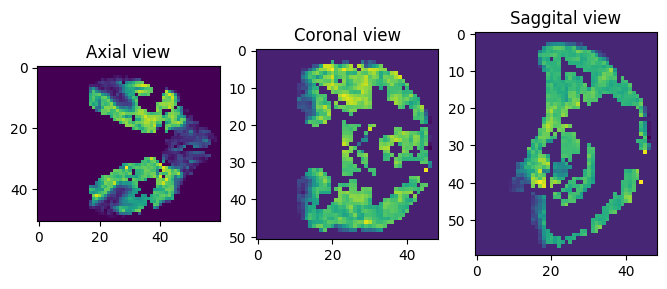

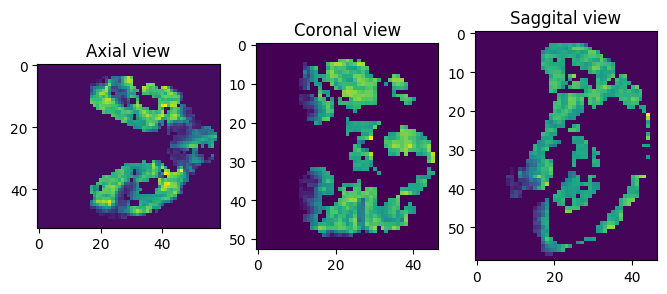

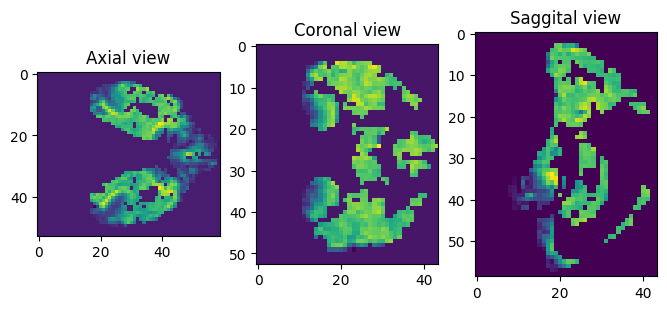

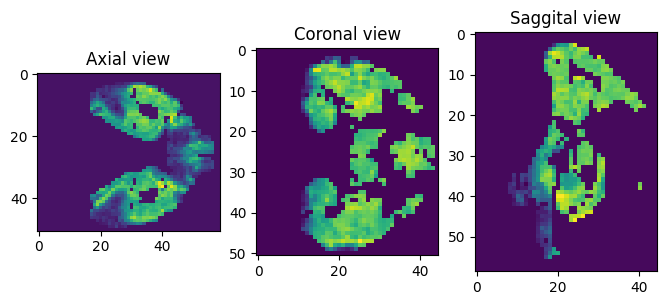

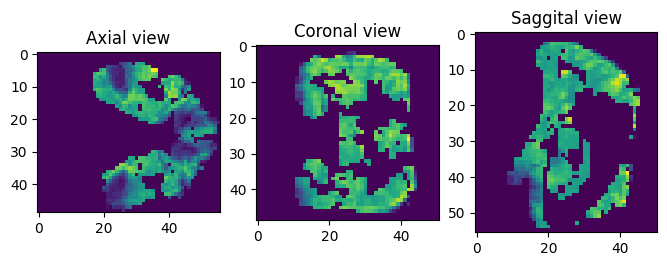

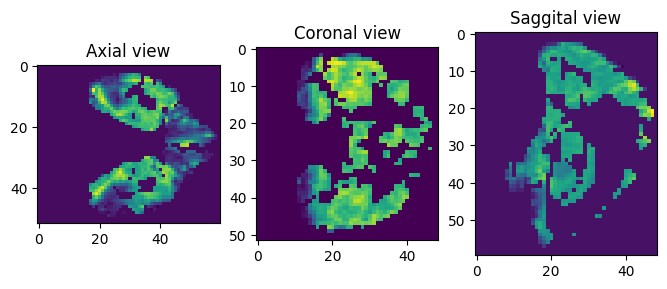

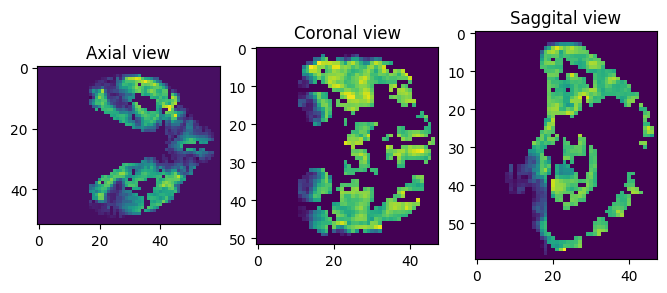

In [4]:
affine_4d = np.eye(4,4)

subjects_4d = []
for f in mat_files:
    mat_contents = sio.loadmat(f)
    print(mat_contents.keys())
    #print(type(mat_contents['data']))
    print(mat_contents['data'].shape)
    #print('({x}, {y}, {z})'.format(x=mat_contents['meta']['dimx'][0][0][0][0], y=mat_contents['meta']['dimy'][0][0][0][0], z=mat_contents['meta']['dimz'][0][0][0][0]))
    n_TRs = mat_contents['data'].shape[0]
    #
    data_4d = build_4d_matrix(mat_contents['meta']['dimx'][0][0][0][0], mat_contents['meta']['dimy'][0][0][0][0], mat_contents['meta']['dimz'][0][0][0][0], n_TRs, mat_contents['data'], mat_contents['meta']['colToCoord'][0][0])
    print(data_4d.shape)
    subjects_4d.append(data_4d)

    img_nii_4d = nib.Nifti1Image(data_4d[:,:,:,:], affine_4d)
    fig, axes = plt.subplots(1,3, figsize=(8,15))
    axes = np.ravel(axes)
    axes[0].imshow(img_nii_4d.get_fdata()[:,:,16,0])
    axes[0].set_title('Axial view');
    axes[1].imshow(img_nii_4d.get_fdata()[:,32,:,0])
    axes[1].set_title('Coronal view');
    axes[2].imshow(img_nii_4d.get_fdata()[32,:,:,0])
    axes[2].set_title('Saggital view');

## Smoothing

In [5]:
import os.path as op
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

For each TR the voxels were treated as a 3D image and smoothed with a gaussian filter (sigma=fwhm / (sqrt(8 * log(2)) * voxelsize, fwhm=6).

Smoothing subject 0 ...
Smoothing subject 1 ...
Smoothing subject 2 ...
Smoothing subject 3 ...
Smoothing subject 4 ...
Smoothing subject 5 ...
Smoothing subject 6 ...
Smoothing subject 7 ...


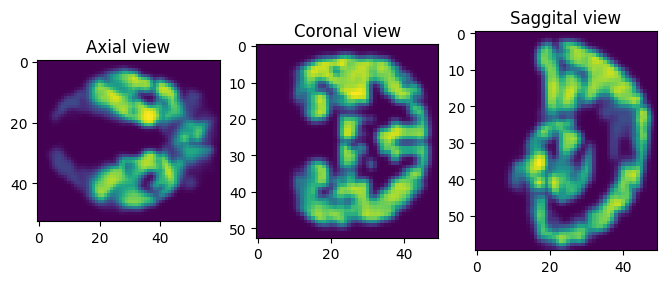

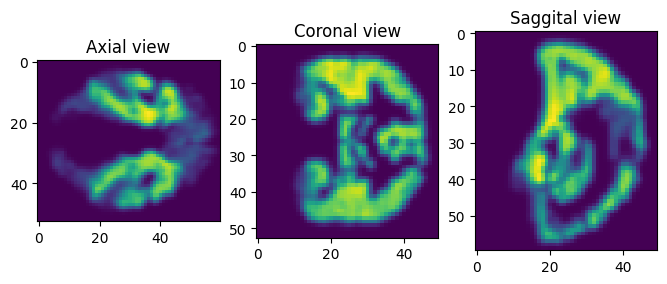

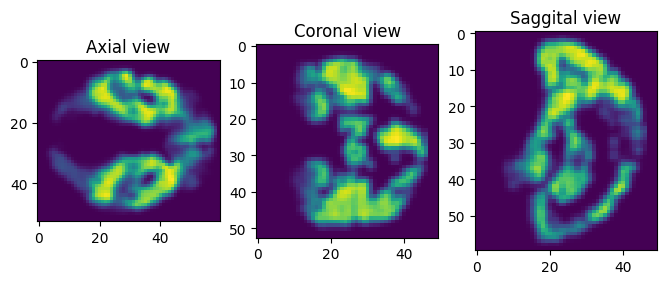

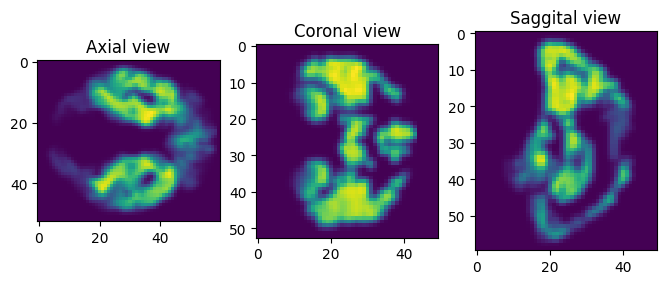

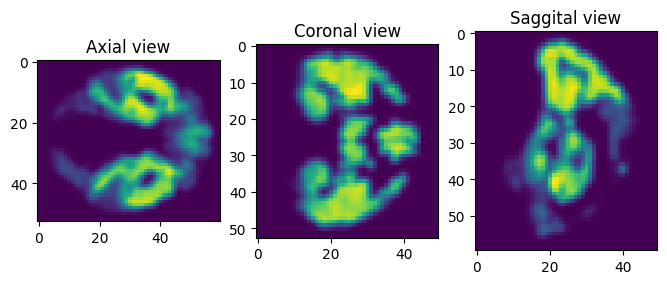

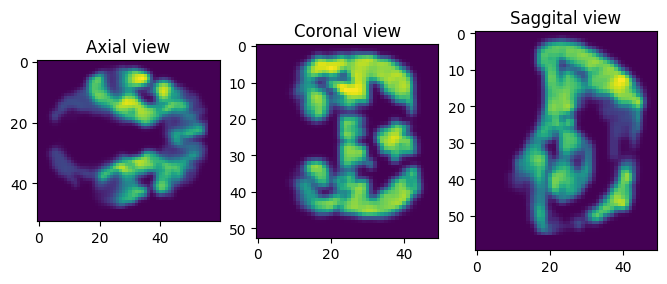

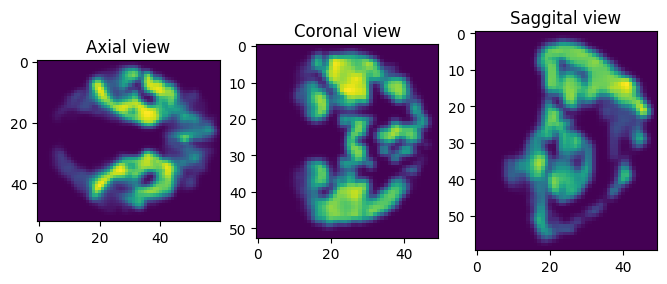

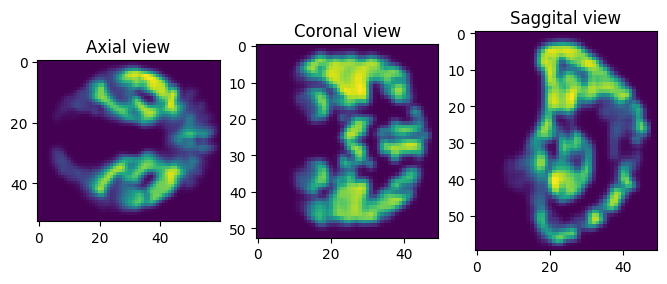

In [6]:
# Taken from https://lukas-snoek.com/NI-edu/fMRI-introduction/week_4/spatial_preprocessing.html
affine_4d = np.eye(4,4)
subj_0_img = None

for subj_id, subj_4d in enumerate(subjects_4d):
    print("Smoothing subject", subj_id, "...")
    fwhm = 6
    voxelsize = 3
    data_4d_smoothed = np.zeros(subj_4d.shape)

    for x in range(subj_4d.shape[3]):
        vol = subj_4d[:, :, :, x]
        sigma = fwhm / (np.sqrt(8 * np.log(2)) * voxelsize)
        smoothed_vol = gaussian_filter(vol, sigma=sigma)
        data_4d_smoothed[:,:,:,x] = smoothed_vol

    smooth_file_name = str(subj_id) + '_smooth_nifti_4d.nii'
    smooth_img_nii_4d = nib.Nifti1Image(data_4d_smoothed[:,:,:,:], affine_4d)
    if subj_id == 0:
        subj_0_img = smooth_img_nii_4d
    else:
        smooth_img_nii_4d = nil.image.resample_to_img(smooth_img_nii_4d, subj_0_img)
    
    nib.save(smooth_img_nii_4d, fMRI_folder / smooth_file_name)

    fig, axes = plt.subplots(1,3, figsize=(8,15))
    axes = np.ravel(axes)
    axes[0].imshow(smooth_img_nii_4d.get_fdata()[:,:,16,0])
    axes[0].set_title('Axial view');
    axes[1].imshow(smooth_img_nii_4d.get_fdata()[:,32,:,0])
    axes[1].set_title('Coronal view');
    axes[2].imshow(smooth_img_nii_4d.get_fdata()[32,:,:,0])
    axes[2].set_title('Saggital view');

## Detrending

In [91]:
from nilearn import plotting
smoothed_data_mc = nib.load(Path('7_smooth_nifti_4d.nii'))
img = nib.Nifti1Image(data_4d_smoothed[:,:,:,44], np.diag([1, 1, 1, 1]))
nii_4D = fMRI_folder / '7_smooth_nifti_4d.nii'

In [94]:
from scipy import signal
#x_detrended = signal.detrend(x)
def plot_voxel_seq(data, x,y,z,t, smoothed=False,nilearn_viz=False):
    scan_time_t = image.index_img(nii_4D, t)
    if smoothed:
      bold_sequence_detrend = signal.detrend(smoothed_data_mc.get_fdata()[x,y,z,:])
      #bold_sequence = smoothed_data_mc.get_fdata()[x,y,z,:]

      if nilearn_viz:
        x2, y2, z2 = image.coord_transform(x,y,z, scan_time_t.affine)
        plotting.plot_img(img, cut_coords=[x2,y2,z2])
    else:
      bold_sequence = smoothed_data_mc.get_fdata()[x,y,z,:]
      if nilearn_viz:
        x2, y2, z2 = image.coord_transform(x,y,z, scan_time_t.affine)
        plotting.plot_img(img, cut_coords=[x2,y2,z2])
    scan_time_t = image.index_img(nii_4D, t)
    fig, axis = plt.subplots(figsize=(10,5))
    #plt.plot(bold_sequence, c='r')
    plt.plot(bold_sequence_detrend, c="b")

    axis.set_ylabel('BOLD Response')
    axis.set_xlabel('TR')
    axis.set_title(f'BOLD Sequence at voxel {x,y,z}')

##Without sequence detrending

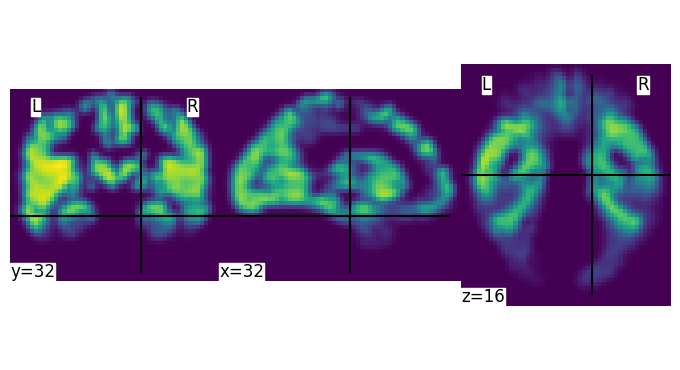

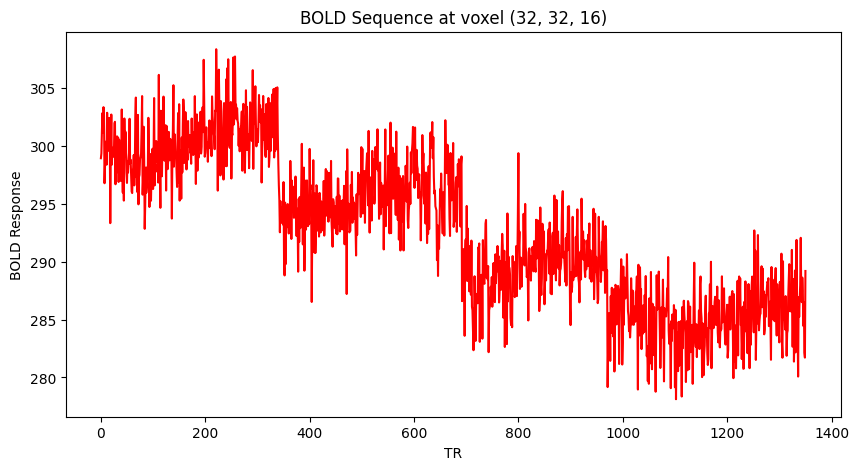

In [93]:
plot_voxel_seq(smoothed_data_mc, x=32, y=32, z=16, t=600, smoothed=True,nilearn_viz=True)

##With sequence detrending

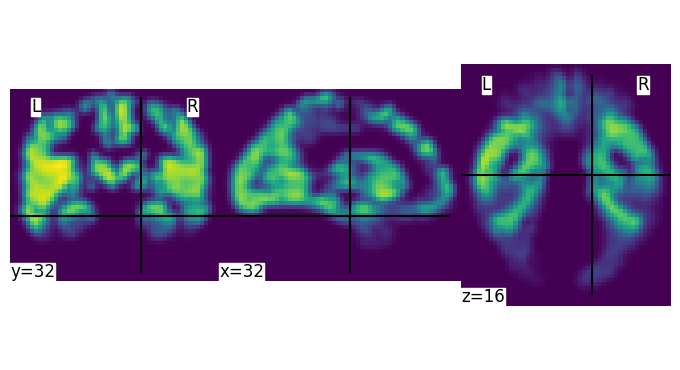

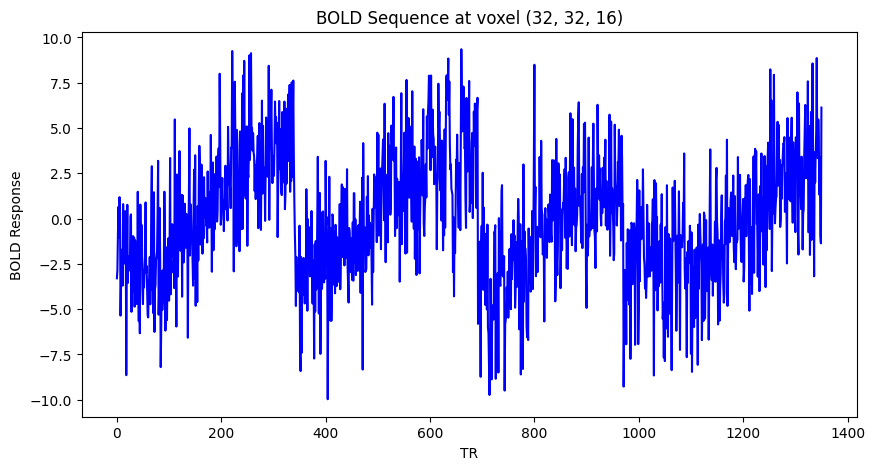

In [95]:
plot_voxel_seq(smoothed_data_mc, x=32, y=32, z=16, t=600, smoothed=True,nilearn_viz=True)

##Detrending at an image level

OSError: [Errno 22] Invalid argument: 'doi_10.5061_dryad.gt413__v1\\7_detrend_nifti_4d.nii'

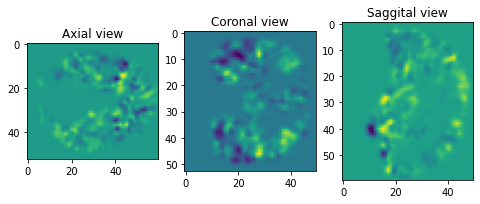

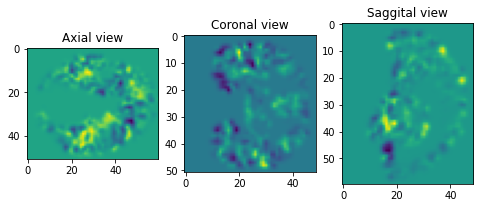

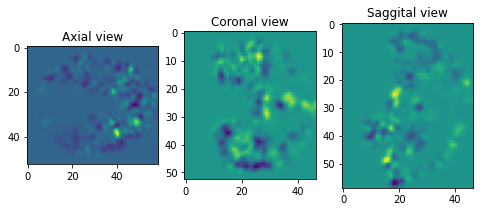

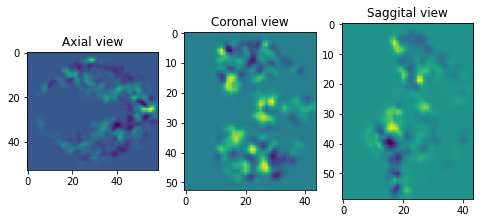

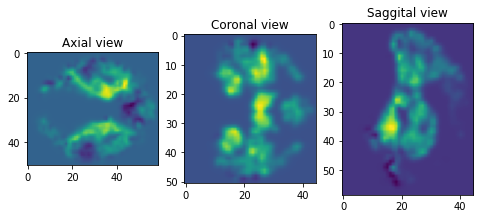

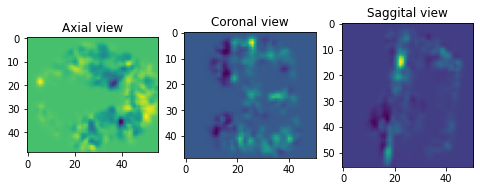

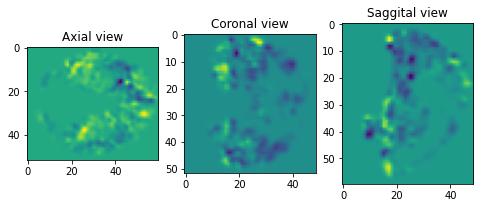

In [ ]:
for subj_id in range(len(subjects_4d)):
    smooth_file_name = str(subj_id) + '_smooth_nifti_4d.nii'
    nii_4D = fMRI_folder / smooth_file_name
    detrend_4d = image.clean_img(nii_4D, detrend=True, standardize=False, t_r=2)
    #detrend_4d = image.clean_img(nii_4D, detrend=False, standardize=False, t_r=2, high_pass=0.005)
    detrend_file_name = str(subj_id) + '_detrend_nifti_4d.nii'
    nib.save(detrend_4d, fMRI_folder / detrend_file_name)

    fig, axes = plt.subplots(1,3, figsize=(8,15))
    axes = np.ravel(axes)
    axes[0].imshow(detrend_4d.get_fdata()[:,:,16,0])
    axes[0].set_title('Axial view');
    axes[1].imshow(detrend_4d.get_fdata()[:,32,:,0])
    axes[1].set_title('Coronal view');
    axes[2].imshow(detrend_4d.get_fdata()[32,:,:,0])
    axes[2].set_title('Saggital view');

## Masking

In [ ]:
for subj_id in range(len(subjects_4d)):
    smooth_file_name = str(subj_id) + '_smooth_nifti_4d.nii'
    #detrend_file_name = str(subj_id) + '_detrend_nifti_4d.nii'
    #nii_4D = fMRI_folder / detrend_file_name
    nii_4D = fMRI_folder / smooth_file_name
    mask = masking.compute_epi_mask(nii_4D, lower_cutoff=0.2, upper_cutoff=0.75)

    data_mc = nib.load(nii_4D)
    masked_2d = masking.apply_mask(nii_4D, mask)

    print(data_mc.shape)
    print(mask.get_fdata().shape)
    print(masked_2d.shape)

    fig, axes = plt.subplots(1,3, figsize=(8,15))
    axes = np.ravel(axes)
    axes[0].imshow(mask.get_fdata()[:,:,16])
    axes[0].set_title('Axial view');
    axes[1].imshow(mask.get_fdata()[:,32,:])
    axes[1].set_title('Coronal view');
    axes[2].imshow(mask.get_fdata()[32,:,:])
    axes[2].set_title('Saggital view');

    fig, axes = plt.subplots(1,3, figsize=(8,15))
    axes = np.ravel(axes)
    axes[0].imshow(data_mc.get_fdata()[:,:,16,0])
    axes[0].set_title('Axial view');
    axes[1].imshow(data_mc.get_fdata()[:,32,:,0])
    axes[1].set_title('Coronal view');
    axes[2].imshow(data_mc.get_fdata()[32,:,:,0])
    axes[2].set_title('Saggital view');

    mask_file_name = str(subj_id) + '_masked_2d.npy'
    np.save(fMRI_folder / mask_file_name, masked_2d)

(53, 60, 50, 1351)
(53, 60, 50)
(1351, 41773)
(51, 60, 49, 1351)
(51, 60, 49)
(1351, 38871)
(53, 59, 47, 1351)
(53, 59, 47)
(1351, 37448)
(53, 59, 44, 1351)
(53, 59, 44)
(1351, 36393)
(51, 59, 45, 1351)
(51, 59, 45)
(1351, 34614)
(49, 56, 51, 1351)
(49, 56, 51)
(1351, 34789)
